In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from matplotlib.colors import ListedColormap

In [ ]:
# Generate XOR dataset
def generate_xor_data(n=200):
    X = np.random.rand(n, 2) * 2 - 1
    y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0).astype(int)
    return X, y

X_train, y_train = generate_xor_data(200)
X_test, y_test = generate_xor_data(200)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

In [ ]:
# Define the basic MLP model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(2, 8)
        self.layer2 = nn.Linear(8, 8)
        self.output_layer = nn.Linear(8, 2)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.output_layer(x)
        return x

In [ ]:
# Train function
def train(model, criterion, optimizer, X, y, epochs=1000):
    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
    return model

In [ ]:
# Define mesh grid for plotting decision boundaries
cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#0000FF'])
h = 0.01
x_min, x_max = X_train[:, 0].min() - 0.5, X_train[:, 0].max() + 0.5
y_min, y_max = X_train[:, 1].min() - 0.5, X_train[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

In [ ]:
# Function to plot decision boundaries
def plot_decision_boundary(model, X, y, title):
    with torch.no_grad():
        Z = model(torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()]))
        Z = torch.argmax(Z, axis=1).numpy()
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=cmap_light)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolor='k', s=20)
    plt.title(title)
    plt.show()

In [ ]:
def evaluate_model(model, X, y):
    with torch.no_grad():
        outputs = model(torch.FloatTensor(X))
        predictions = torch.argmax(outputs, dim=1).numpy()

    accuracy = accuracy_score(y, predictions)
    precision = precision_score(y, predictions)
    recall = recall_score(y, predictions)
    f1 = f1_score(y, predictions)

    return accuracy, precision, recall, f1

MLP without Regularization - Accuracy: 0.9600, Precision: 0.9904, Recall: 0.9364, F1 Score: 0.9626


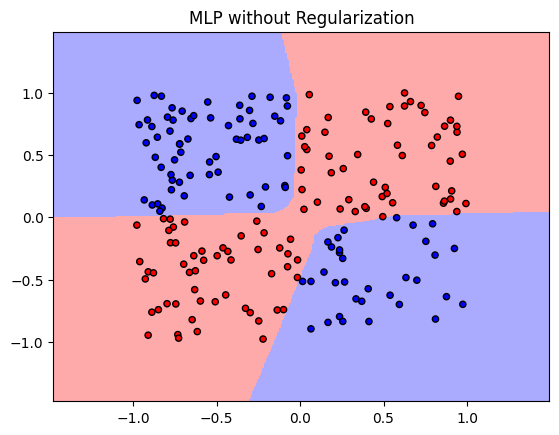

MLP with L1 Regularization - Accuracy: 0.9950, Precision: 1.0000, Recall: 0.9909, F1 Score: 0.9954


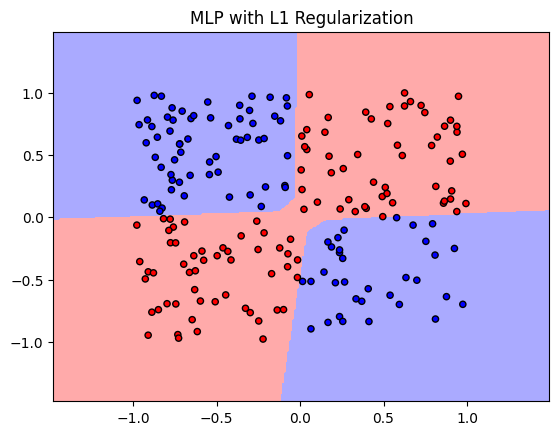

MLP with L2 Regularization - Accuracy: 0.9550, Precision: 1.0000, Recall: 0.9182, F1 Score: 0.9573


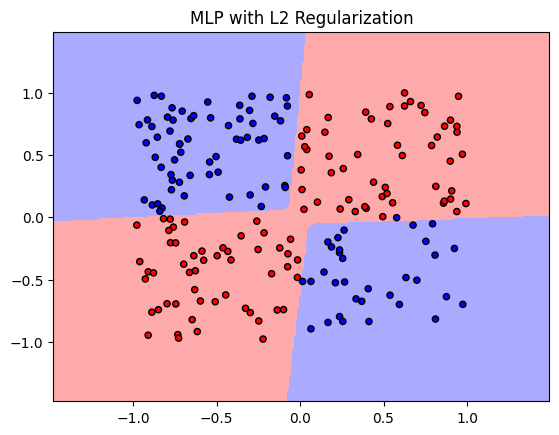

Logistic Regression with Polynomial Features - Accuracy: 0.8950, Precision: 1.0000, Recall: 0.8091, F1 Score: 0.8945


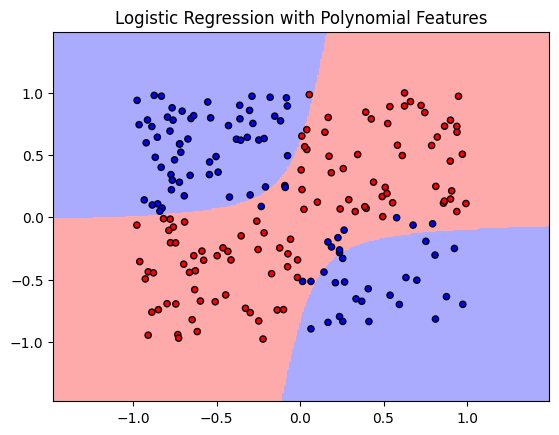

In [ ]:
# Train and evaluate MLP without regularization
model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
trained_model = train(model, criterion, optimizer, X_train_tensor, y_train_tensor)

# Evaluate and print metrics
acc, prec, rec, f1 = evaluate_model(trained_model, X_test, y_test)
print(f"MLP without Regularization - Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1:.4f}")

plot_decision_boundary(trained_model, X_train, y_train, title="MLP without Regularization")

# MLP with L1 regularization (manual L1 penalty)
model_l1 = MLP()
optimizer_l1 = optim.Adam(model_l1.parameters(), lr=0.01)
lambda_l1 = 0.001  # L1 penalty term
for epoch in range(1000):
    optimizer_l1.zero_grad()
    output = model_l1(X_train_tensor)
    loss = criterion(output, y_train_tensor)
    l1_norm = sum(p.abs().sum() for p in model_l1.parameters())
    loss += lambda_l1 * l1_norm
    loss.backward()
    optimizer_l1.step()

# Evaluate and print metrics for L1 regularization
acc_l1, prec_l1, rec_l1, f1_l1 = evaluate_model(model_l1, X_test, y_test)
print(f"MLP with L1 Regularization - Accuracy: {acc_l1:.4f}, Precision: {prec_l1:.4f}, Recall: {rec_l1:.4f}, F1 Score: {f1_l1:.4f}")

plot_decision_boundary(model_l1, X_train, y_train, title="MLP with L1 Regularization")

# MLP with L2 regularization (using weight decay)
model_l2 = MLP()
optimizer_l2 = optim.Adam(model_l2.parameters(), lr=0.01, weight_decay=0.01)  # L2 regularization
trained_model_l2 = train(model_l2, criterion, optimizer_l2, X_train_tensor, y_train_tensor)

# Evaluate and print metrics for L2 regularization
acc_l2, prec_l2, rec_l2, f1_l2 = evaluate_model(trained_model_l2, X_test, y_test)
print(f"MLP with L2 Regularization - Accuracy: {acc_l2:.4f}, Precision: {prec_l2:.4f}, Recall: {rec_l2:.4f}, F1 Score: {f1_l2:.4f}")

plot_decision_boundary(trained_model_l2, X_train, y_train, title="MLP with L2 Regularization")

# Logistic regression with polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
log_reg = LogisticRegression()
log_reg.fit(X_train_poly, y_train)

# Predict and plot decision boundary for logistic regression
xx_poly = poly.transform(np.c_[xx.ravel(), yy.ravel()])
Z_poly = log_reg.predict(xx_poly)
Z_poly = Z_poly.reshape(xx.shape)

# Evaluate and print metrics for logistic regression
log_reg_preds = log_reg.predict(X_test_poly)
acc_log_reg = accuracy_score(y_test, log_reg_preds)
prec_log_reg = precision_score(y_test, log_reg_preds)
rec_log_reg = recall_score(y_test, log_reg_preds)
f1_log_reg = f1_score(y_test, log_reg_preds)

print(f"Logistic Regression with Polynomial Features - Accuracy: {acc_log_reg:.4f}, Precision: {prec_log_reg:.4f}, Recall: {rec_log_reg:.4f}, F1 Score: {f1_log_reg:.4f}")

plt.contourf(xx, yy, Z_poly, cmap=cmap_light)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap_bold, edgecolor='k', s=20)
plt.title("Logistic Regression with Polynomial Features")
plt.show()